In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [0]:
from imageio import imread
from glob import glob
from imgaug import augmenters as iaa
import cv2

In [0]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
# from skimage.transform import resize

In [5]:
from google.colab import files
ninja_turtle = files.upload()

Saving ninja_turtle.png to ninja_turtle.png


In [6]:
!ls

ninja_turtle.png  sample_data


In [7]:
ninja_turtle = imread('ninja_turtle.png')
ninja_turtle.shape

(113, 64, 4)

In [8]:
type(ninja_turtle)

imageio.core.util.Array

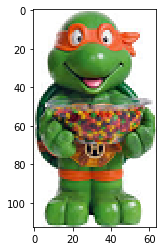

In [9]:
plt.imshow(ninja_turtle)

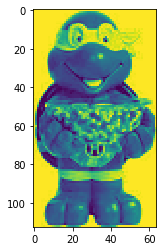

In [10]:
# Let's check the 4 channels
plt.imshow(ninja_turtle[:,:,0])

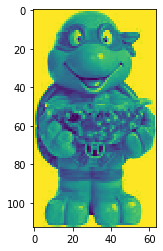

In [11]:
plt.imshow(ninja_turtle[:,:,1])

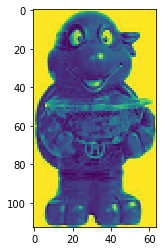

In [12]:
plt.imshow(ninja_turtle[:,:,2])

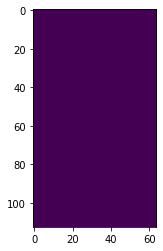

In [13]:
plt.imshow(ninja_turtle[:,:,3])

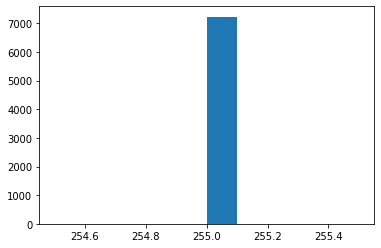

{255}

In [14]:
plt.hist(ninja_turtle[:,:,3].flatten())
plt.show()
set(ninja_turtle[:,:,3].flatten())

In [15]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-01-29 19:37:16--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   308KB/s    in 1.6s    

2020-01-29 19:37:25 (308 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [16]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [17]:
!ls

backgrounds  backgrounds.zip  __MACOSX	ninja_turtle.png  sample_data


In [18]:
# Let's print random images
random_background_image = imread('backgrounds/1.jpg')
random_background_image.shape

(224, 315, 3)

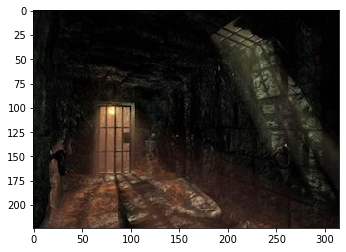

In [19]:
plt.imshow(random_background_image)

In [0]:
background_images = glob('backgrounds/*.jpg')
# print(background_images)     ['backgrounds/9.jpg', 'backgrounds/4.jpg', 'backgrounds/10.jpg', 
#                               'backgrounds/15.jpg', 'backgrounds/7.jpg', 'backgrounds/2.jpg', 
#                               'backgrounds/11.jpg', 'backgrounds/12.jpg', 'backgrounds/6.jpg', 
#                               'backgrounds/1.jpg', 'backgrounds/5.jpg', 'backgrounds/13.jpg', 
#                               'backgrounds/14.jpg', 'backgrounds/3.jpg', 'backgrounds/8.jpg']

In [0]:
batch_size = 32

In [0]:
def augmentation(image):

  if np.random.rand() < 0.5:
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)

  if np.random.rand() < 0.5:
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
  
  if np.random.rand() < 0.5:
    aug = iaa.Resize((20, 50))  # Resize all images to a random height and width within the discrete interval [20..50]
    image = aug.augment_image(image)

  if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)  # flip horizontally

  if np.random.rand() < 0.5:
    image = cv2.flip(image, 0)  # flip vertically

  return image

In [0]:
def resize_image(image):
  return cv2.resize(image, (200, 200))

In [0]:
DIM = 200

def batch_generator():

  while True:

    X = np.zeros((batch_size, DIM, DIM, 3))    # (32, 200, 200, 3)
    Y = np.zeros((batch_size, 4))              # (32, 4)

    for i in range(batch_size):

      # resize the background images to 200x200
      random_index = np.random.randint(0, len(background_images) - 1)
      image = imread(background_images[random_index])        # (224, 335, 3)
      image = resize_image(image)                            # (200, 200, 3)
      image_H, image_W, _ = image.shape

      # perform augmentation on the ninja turtle image
      nt_aug = augmentation(ninja_turtle)
      nt_H, nt_W, _ = nt_aug.shape
      
      # choose a random location to store the object
      row0 = np.random.randint(image_H - nt_H)
      col0 = np.random.randint(image_W - nt_W)
      row1 = row0 + nt_H
      col1 = col0 + nt_W

      X[i] = np.expand_dims(image, axis=0)
      X[i,row0:row1,col0:col1,:] = nt_aug[:,:,:3]
      
      # make targets
      # Below two numbers represent the top left corner of the box 
      Y[i,0] = row0/DIM
      Y[i,1] = col0/DIM
      
      # Below two numbers represent height & width of the box
      Y[i,2] = (row1 - row0)/DIM
      Y[i,3] = (col1 - col0)/DIM
    
    yield X / 255., Y

In [0]:
vgg = VGG16(input_shape=[DIM, DIM, 3], weights='imagenet', include_top=False)

In [84]:
print(vgg.input.shape)
print(vgg.output.shape)

(None, 200, 200, 3)
(None, 6, 6, 512)


In [0]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)

In [0]:
model = Model(vgg.input, x)             # Same as model = Model(inputs=vgg.input, outputs=x)

In [0]:
model.compile(
    loss='mean_squared_error', 
    optimizer=Adam(lr=0.0001)
)

In [88]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [89]:
model.fit_generator(
    batch_generator(),
    steps_per_epoch=50,
    epochs=5,
)

  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/5
50/50 [==============================] - 20s 395ms/step - loss: 0.0134
Epoch 2/5
50/50 [==============================] - 20s 400ms/step - loss: 0.0011
Epoch 3/5
50/50 [==============================] - 20s 391ms/step - loss: 4.6832e-04
Epoch 4/5
50/50 [==============================] - 19s 383ms/step - loss: 3.2120e-04
Epoch 5/5
50/50 [==============================] - 19s 383ms/step - loss: 2.7249e-04


In [0]:
# Make predictions
def prediction():

  random_index = np.random.randint(0, len(background_images) - 1)
  image = imread(background_images[random_index])
  image = resize_image(image)
  image_H, image_W, _ = image.shape

  nt_aug = augmentation(ninja_turtle)
  nt_H, nt_W, _ = nt_aug.shape
    
  # choose a random location to store the object
  row0 = np.random.randint(image_H - nt_H)
  col0 = np.random.randint(image_W - nt_W)
  row1 = row0 + nt_H
  col1 = col0 + nt_W
        
  image[row0:row1,col0:col1,:] = nt_aug[:,:,:3]
  print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(image, axis=0) / 255.     # Always equal to (1, 200, 200, 3)
  p = model.predict(X)[0]
  print(p)
  # print(p.shape)                             (4,)               
  
  # Predicted rows & columns
  row0 = int(p[0]*DIM)
  col0 = int(p[1]*DIM)
  row1 = int(row0 + p[2]*DIM)
  col1 = int(col0 + p[3]*DIM)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  rect = Rectangle(
      (p[1]*DIM, p[0]*DIM),
      p[3]*DIM, p[2]*DIM,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

true: 56 106 169 170
[0.26575974 0.5117217  0.583297   0.3189236 ]
pred: 53 102 169 165


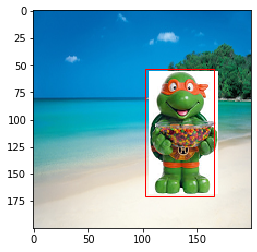

In [102]:
prediction()